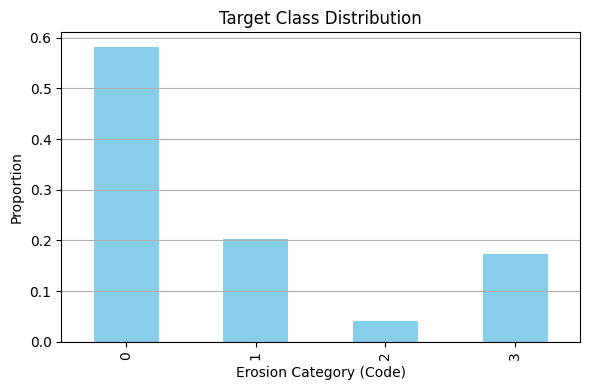

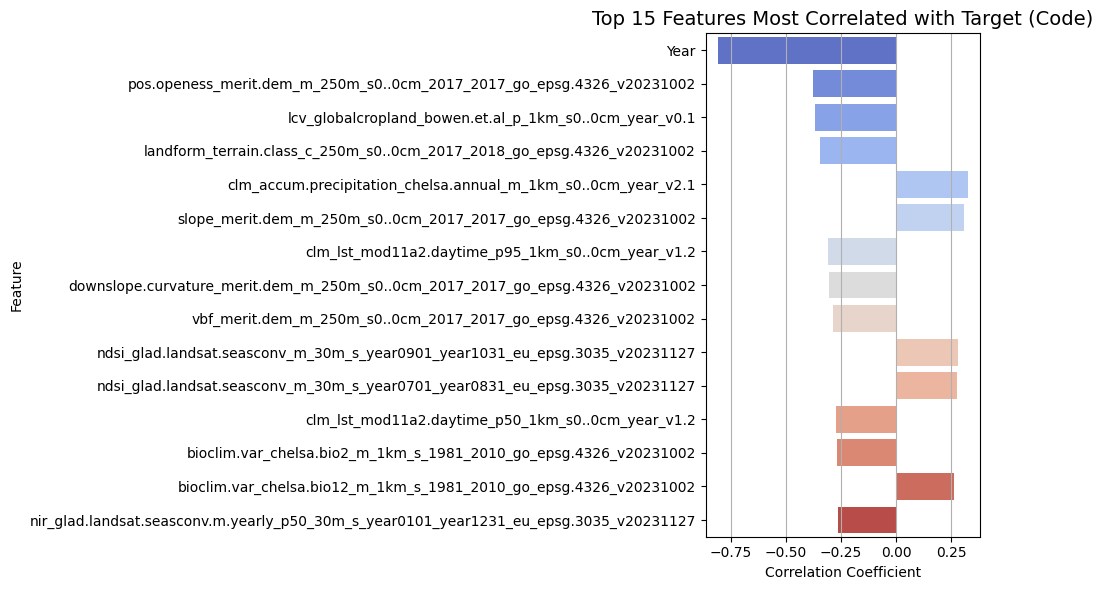

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10323
[LightGBM] [Info] Number of data points in the train set: 3003, number of used features: 129
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Validation Accuracy: 0.8309


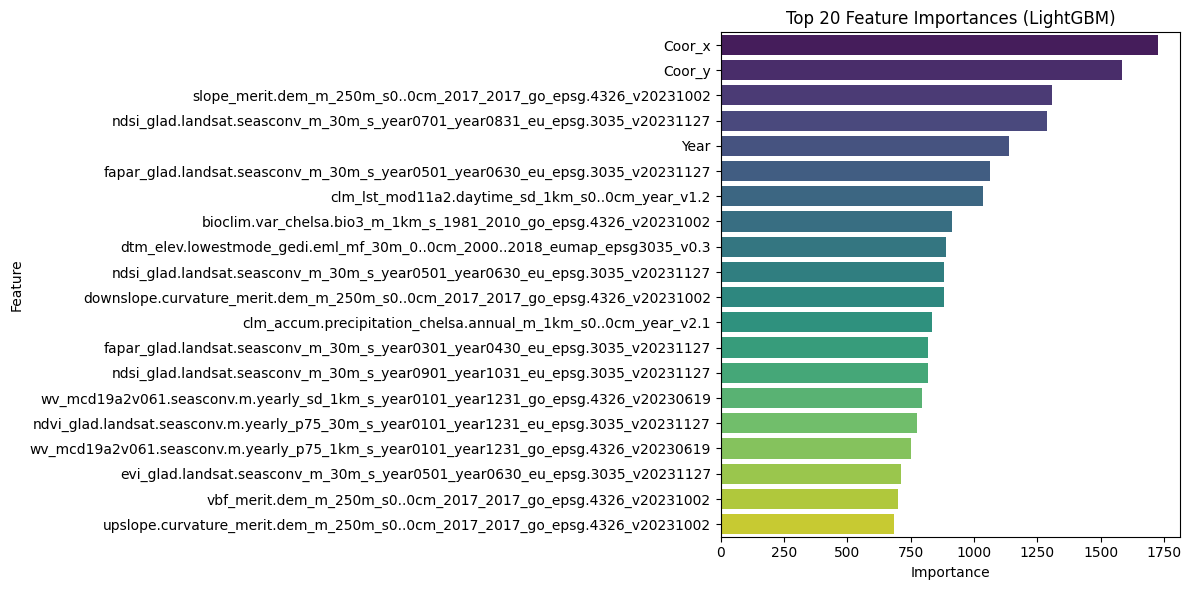

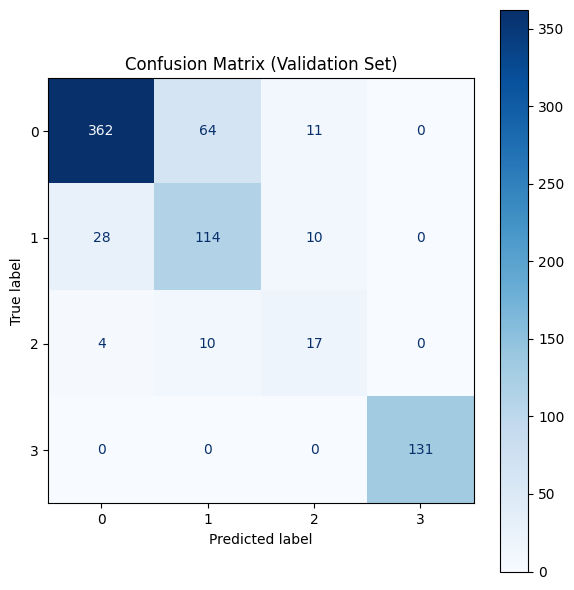

✅ 'submission.csv' created


In [14]:
# 📦 Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os

# 📁 Ensure output directory exists
os.makedirs("plots", exist_ok=True)

# ✅ Load Data
train_df = pd.read_csv('/kaggle/input/esa-eo4soilprotection-2024-predicting-erosion-cat/train_erosion.csv')
test_df = pd.read_csv('/kaggle/input/esa-eo4soilprotection-2024-predicting-erosion-cat/test_erosion.csv')

# 🧹 Drop object columns like UUID
train_df = train_df.drop(columns=train_df.select_dtypes(include='object').columns)
test_df = test_df.drop(columns=test_df.select_dtypes(include='object').columns)

# 🧽 Sanitize column names
def clean_column_name(col):
    return re.sub(r'[\"\'{}\[\]:,]', '', col)

train_df.columns = [clean_column_name(col) for col in train_df.columns]
test_df.columns = [clean_column_name(col) for col in test_df.columns]

# 🎯 Features and target
target_col = 'Code'
id_col = 'sample_id'

X = train_df.drop([target_col, id_col], axis=1)
y = train_df[target_col]
X_test = test_df.drop([id_col], axis=1)

# 📊 Plot 1: Class Distribution
plt.figure(figsize=(6, 4))
y.value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
plt.title("Target Class Distribution")
plt.xlabel("Erosion Category (Code)")
plt.ylabel("Proportion")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("plots/class_distribution.png")
plt.show()

# 🧠 Correlation with target
correlations = train_df.corr()[target_col].drop(target_col).sort_values(key=abs, ascending=False).head(15)

# 📊 Plot: Clean horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Top 15 Features Most Correlated with Target (Code)", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("plots/top15_feature_correlations_clean.png")
plt.show()


# 🪓 Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🧠 LightGBM Classifier
model = lgb.LGBMClassifier(
    num_leaves=50,
    max_depth=-1,
    learning_rate=0.01,
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

# 🚀 Train
model.fit(X_train, y_train)

# 🧪 Validate
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# 📊 Plot 3: Feature Importance
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.tight_layout()
plt.savefig("plots/feature_importance.png")
plt.show()

# 📊 Plot 4: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png")
plt.show()

# 📁 Predict & Submit
y_test_pred = model.predict(X_test)
submission = pd.DataFrame({
    'sample_id': test_df[id_col],
    'Code': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("✅ 'submission.csv' created")


In [15]:
import joblib

# Save model
joblib.dump(model, "lgbm_erosion_model.pkl")
print("✅ Model saved as 'lgbm_erosion_model.pkl'")


✅ Model saved as 'lgbm_erosion_model.pkl'


In [17]:
# To reuse later in your app
model = joblib.load("lgbm_erosion_model.pkl")


In [22]:
print("Shape of input data:", train_df.shape)  # should be (1, 136)


Shape of input data: (3754, 138)


In [23]:
# During training (do this if you still have access)
feature_names = list(X_train.columns)
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']

In [31]:
# soil_cnn_train.py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    '/kaggle/input/soil-types/Soil types',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/kaggle/input/soil-types/Soil types',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=13)

model.save("soil_type_cnn_model.h5")


Found 126 images belonging to 5 classes.
Found 30 images belonging to 5 classes.
Epoch 1/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - accuracy: 0.2422 - loss: 2.5766 - val_accuracy: 0.2333 - val_loss: 2.0140
Epoch 2/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3187 - loss: 1.9361 - val_accuracy: 0.4333 - val_loss: 1.1861
Epoch 3/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4043 - loss: 1.2207 - val_accuracy: 0.4333 - val_loss: 1.0904
Epoch 4/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5657 - loss: 1.0330 - val_accuracy: 0.7000 - val_loss: 0.8985
Epoch 5/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6761 - loss: 0.8084 - val_accuracy: 0.5333 - val_loss: 0.7736
Epoch 6/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7806 - loss: 0.6362 - val_accuracy: 0.7333 - val_loss: 0.6637
Epoch 7/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7677 - loss: 0.5117 - val_accuracy: 0.7333 - val_loss: 0.6218
Epoch 8/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms

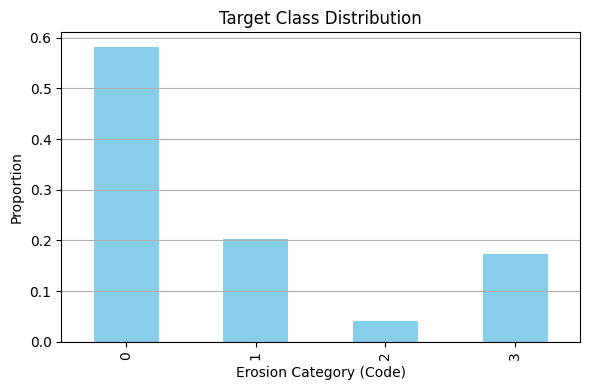

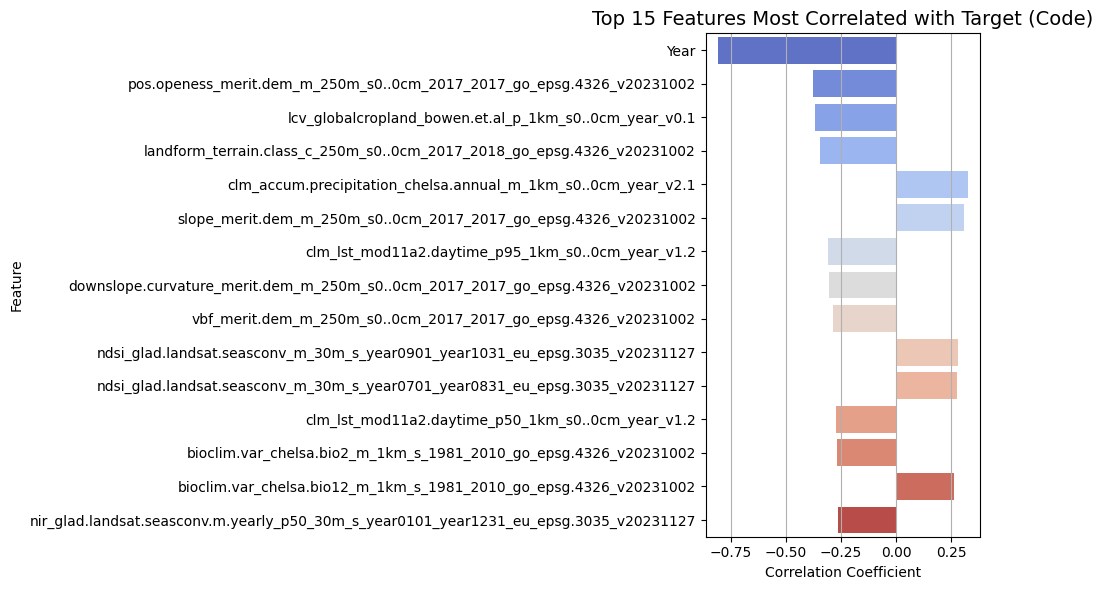

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10323
[LightGBM] [Info] Number of data points in the train set: 3003, number of used features: 129
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Full Model] Validation Accuracy: 0.8309


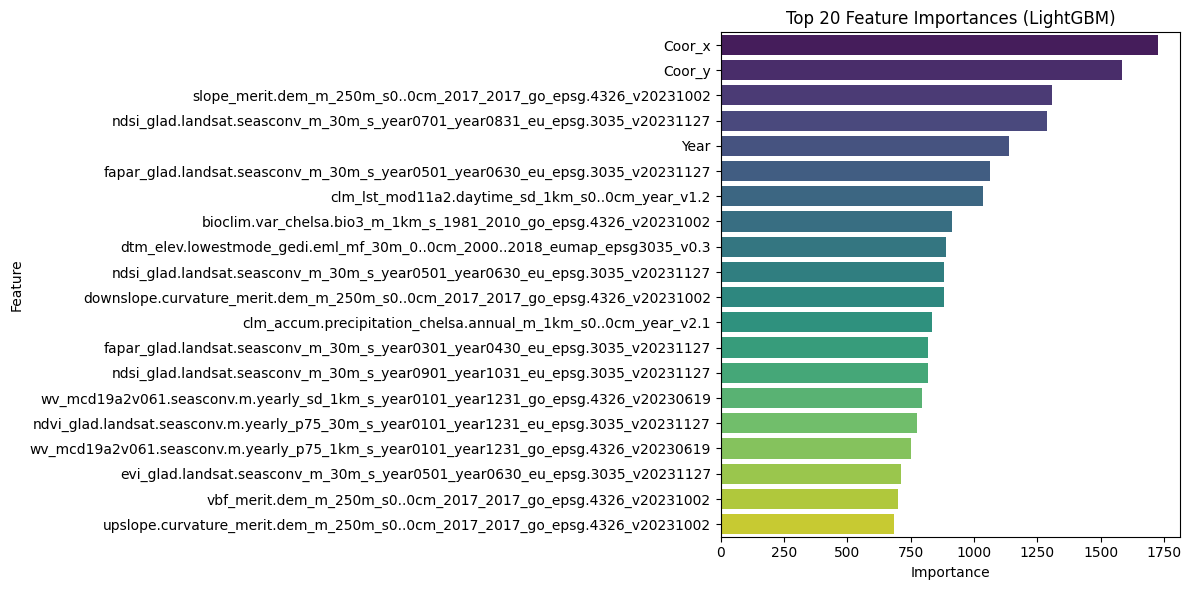

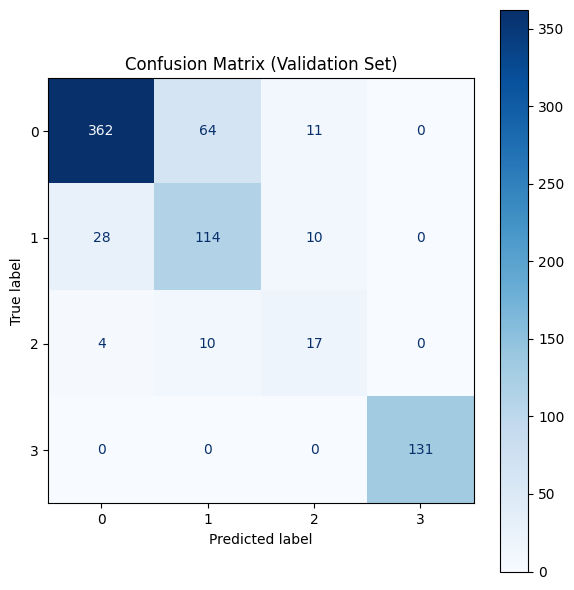

✅ 'submission.csv' created
✅ Full model and feature list saved.
🔁 Training light model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 3003, number of used features: 13
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [34]:
# 📦 Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os

# 📁 Ensure output directory exists
os.makedirs("plots", exist_ok=True)

# ✅ Load Data
train_df = pd.read_csv('/kaggle/input/esa-eo4soilprotection-2024-predicting-erosion-cat/train_erosion.csv')
test_df = pd.read_csv('/kaggle/input/esa-eo4soilprotection-2024-predicting-erosion-cat/test_erosion.csv')

# 🧹 Drop object columns like UUID
train_df = train_df.drop(columns=train_df.select_dtypes(include='object').columns)
test_df = test_df.drop(columns=test_df.select_dtypes(include='object').columns)

# 🧽 Sanitize column names
def clean_column_name(col):
    return re.sub(r'[\"\'{}\[\]:,]', '', col)

train_df.columns = [clean_column_name(col) for col in train_df.columns]
test_df.columns = [clean_column_name(col) for col in test_df.columns]

# 🎯 Features and target
target_col = 'Code'
id_col = 'sample_id'

# ========== FULL MODEL ==========
X_full = train_df.drop([target_col, id_col], axis=1)
y = train_df[target_col]

X_test = test_df.drop([id_col], axis=1)

# 📊 Plot 1: Class Distribution
plt.figure(figsize=(6, 4))
y.value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
plt.title("Target Class Distribution")
plt.xlabel("Erosion Category (Code)")
plt.ylabel("Proportion")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("plots/class_distribution.png")
plt.show()

# 🧠 Correlation with target
correlations = train_df.corr()[target_col].drop(target_col).sort_values(key=abs, ascending=False).head(15)

# 📊 Plot 2: Clean barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Top 15 Features Most Correlated with Target (Code)", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("plots/top15_feature_correlations_clean.png")
plt.show()

# 🪓 Train/Val Split
X_train_full, X_val_full, y_train, y_val = train_test_split(X_full, y, stratify=y, test_size=0.2, random_state=42)

# 🧠 Train Full LightGBM Classifier
full_model = lgb.LGBMClassifier(
    num_leaves=50,
    max_depth=-1,
    learning_rate=0.01,
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
full_model.fit(X_train_full, y_train)

# 📈 Full Model Validation
y_val_pred = full_model.predict(X_val_full)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"[Full Model] Validation Accuracy: {val_acc:.4f}")

# 📊 Plot 3: Feature Importance
importances = full_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.tight_layout()
plt.savefig("plots/feature_importance.png")
plt.show()

# 📊 Plot 4: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png")
plt.show()

# 📁 Predict & Save Submission
y_test_pred = full_model.predict(X_test)
submission = pd.DataFrame({
    'sample_id': test_df[id_col],
    'Code': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("✅ 'submission.csv' created")

# 💾 Save Full Model
joblib.dump(full_model, "full_model.pkl")
joblib.dump(X_full.columns.tolist(), "full_features.pkl")
print("✅ Full model and feature list saved.")

# ========== LIGHT MODEL ==========
print("🔁 Training light model...")

# Mapping from user-friendly names to dataset columns
light_feature_mapping = {
    "year": "Year",
    "slope": "slope_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002",
    "openness": "pos.openess_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002",
    "curvature_up": "upslope.curvature_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002",
    "curvature_down": "downslope.curvature_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002",
    "ndvi": "ndvi_glad.landsat.seasconv.m.yearly_p75_30m_s_year0101_year1231_eu_epsg.3035_v20231127",
    "red": "red_glad.landsat.seasconv.m.yearly_p75_30m_s_year0101_year1231_eu_epsg.3035_v20231127",
    "green": "green_glad.landsat.seasconv.m.yearly_p75_30m_s_year0101_year1231_eu_epsg.3035_v20231127",
    "blue": "blue_glad.landsat.seasconv.m.yearly_p75_30m_s_year0101_year1231_eu_epsg.3035_v20231127",
    "nir": "nir_glad.landsat.seasconv.m.yearly_p75_30m_s_year0101_year1231_eu_epsg.3035_v20231127",
    "temperature": "clm_lst_mod11a2.daytime_p50_1km_s0..0cm_year_v1.2",
    "precipitation": "clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm_year_v2.1",
    "lithology": "dtm_lithology_usgs.ecotapestry.unconsolidated.sediment_p_250m_s0..0cm_2014_v1.0"
}

# Create list of actual dataset columns
light_actual_columns = list(light_feature_mapping.values())

# Filter the dataset
light_df = train_df[light_actual_columns + [target_col]].copy()
X_light = light_df.drop(columns=[target_col])
y_light = light_df[target_col]

# Train/val split
from sklearn.model_selection import train_test_split
X_train_light, X_val_light, y_train_light, y_val_light = train_test_split(
    X_light, y_light, stratify=y_light, test_size=0.2, random_state=42
)

# Train model
light_model = lgb.LGBMClassifier(
    num_leaves=40,
    max_depth=7,
    learning_rate=0.05,
    n_estimators=150,
    class_weight='balanced',
    random_state=42
)
light_model.fit(X_train_light, y_train_light)

# Evaluate
from sklearn.metrics import accuracy_score
y_pred_light = light_model.predict(X_val_light)
acc_light = accuracy_score(y_val_light, y_pred_light)
print(f"[Light Model] Accuracy: {acc_light:.4f}")

# Save
import joblib
joblib.dump(light_model, "light_model.pkl")
joblib.dump(light_actual_columns, "light_features.pkl")
print("✅ Light model and feature list saved.")


